# 1.Импорт модулей

In [ ]:
# !pip install gensim --upgrade -q  # апгрейд пакета генсим

In [ ]:
import pandas as pd  
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import re
from tqdm import tqdm
import urllib.request
import gensim
from gensim.models import word2vec
from gensim.test.utils import datapath
from gensim import utils
from google.colab import files
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

!pip install pymorphy2 -q
from pymorphy2 import MorphAnalyzer
from functools import lru_cache
from multiprocessing import Pool

from sklearn.model_selection import train_test_split

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import f1_score

from lightgbm import LGBMClassifier
!pip install catboost -q
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
!pip install transformers -q

In [ ]:
import transformers

from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, BertForSequenceClassification
import torch
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import random

In [ ]:
RANDOM_SEED = 42
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def seed_all(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False
seed_all(RANDOM_SEED)

# 2.Анализ данных.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/MyDrive/Colab\ Notebooks/NLP/bootcamp/train_dl.csv.zip -d /content/data
!unzip -q /content/drive/MyDrive/Colab\ Notebooks/NLP/bootcamp/new_test_dl.csv.zip -d /content/data

In [ ]:
train_df = pd.read_csv('/content/data/train_dl.csv')
test_df = pd.read_csv('/content/data/new_test_dl.csv', index_col=0)

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP/bootcamp/train_clean.csv')
train_df.head()

,bank,feeds,grades,date,sym_len,word_len,lemmas
0,unicreditbank,Я очень редко пользуюсь банковскими продуктами...,5.0,2017-12-31 18:20:00,770,119,очень редко пользоваться банковский продукт не...
1,fk_otkritie,Я вместе с женой 15.11.2019 обратился в отделе...,1.0,2019-11-22 22:42:00,2749,405,вместе жена обратиться отделение банк открытие...
2,alfabank,Добрый день.Сегодня 27.12.2018 г около 15.40-1...,1.0,2018-12-27 23:20:00,867,128,добрый день сегодня г около банкомат адрес ряз...
3,vtb,"""Где карточку открывали, туда и идите..."" - эт...",2.0,2020-02-05 16:40:00,2860,462,карточка открывать туда идти этот фраза давно ...
4,promsvyazbank,При покупках в iTunes списываются завышенные с...,NaN,2016-02-26 15:48:00,1066,161,покупка itunes списываться завысить сумма прим...


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP/bootcamp/test_clean.csv')
test_df.head()

,bank,feeds,date,lemmas
0,sberbank,История такова: 27.01.2015 мне на телефон приш...,05.02.2015 17:33,история таков телефон прийти подряд смс списан...
1,alfabank,"Нельзя решить ни один вопрос оперативно, автоо...",03.03.2021 9:27,решить вопрос оперативно автоответчик отказыва...
2,tcs,"Быстро, удобно, чего ещё нужно то. На сайтике ...",09.04.2018 7:40,быстро удобно нужно сайтик быстро оформить док...
3,pochtabank,Добрый день! Просто в шоке от ПАО «Почта Банк...,09.04.2020 9:57,добрый день просто шок пао почта банк обратить...
4,sberbank,В течение выходных дней новогоднего периода 20...,12.01.2012 14:00,течение выходной день новогодний период банком...


In [ ]:
train_df.head(10)

,bank,feeds,grades,date
0,unicreditbank,Я очень редко пользуюсь банковскими продуктами...,5.0,31.12.2017 18:20
1,fk_otkritie,Я вместе с женой 15.11.2019 обратился в отделе...,1.0,22.11.2019 22:42
2,alfabank,Добрый день.Сегодня 27.12.2018 г около 15.40-1...,1.0,27.12.2018 23:20
3,vtb,"""Где карточку открывали, туда и идите..."" - эт...",2.0,05.02.2020 16:40
4,promsvyazbank,При покупках в iTunes списываются завышенные с...,NaN,26.02.2016 15:48
5,pochtabank,08.02.2018 я оформил кредит наличными в отделе...,1.0,21.03.2018 18:03
6,otpbank,06.06.2016 по платежному поручению №916 через ...,NaN,16.09.2016 10:55
7,homecreditbank,Всем доброго времени суток! С банком в принцип...,NaN,15.03.2017 22:12
8,vtb,Обслуживался как физ лицо. Была дебетовая карт...,1.0,11.07.2019 22:02
9,fk_otkritie,"У меня зарплатная карта, обратилась в филиал б...",1.0,22.09.2017 21:54


In [ ]:
train_df.shape

(350000, 4)

In [ ]:
train_df.isna().sum()

bank           0
feeds          0
grades    109750
date           0
dtype: int64

In [ ]:
train_df.grades.unique()

array([ 5.,  1.,  2., nan,  3.,  4.])

In [ ]:
print('Доля пропусков в столбце с лейблами:', round(train_df.grades.isna().sum() / train_df.shape[0] * 100, 2))

Доля пропусков в столбце с лейблами: 31.36


In [ ]:
train_df.dtypes

bank       object
feeds      object
grades    float64
date       object
dtype: object

In [ ]:
train_df.bank.nunique()

69

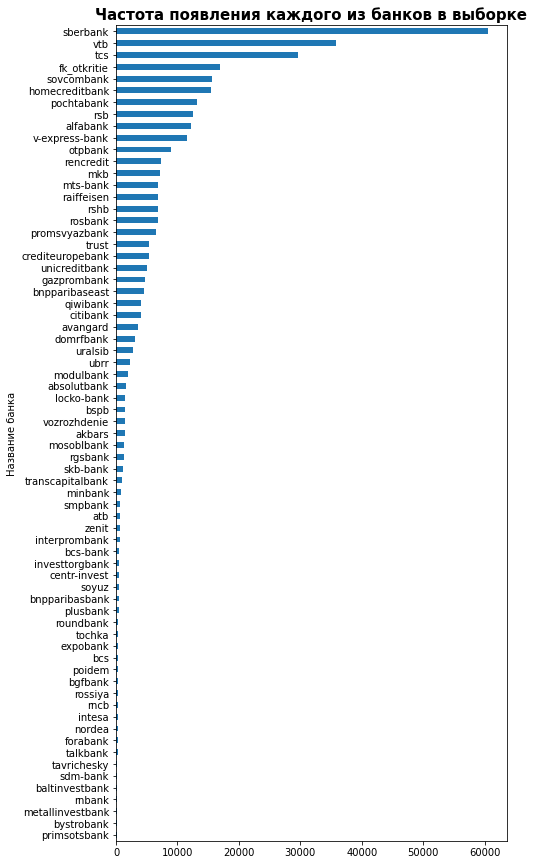

In [ ]:
banks_freq = train_df.bank.value_counts(ascending=True)
fig = plt.figure(figsize=(7, 15))
banks_freq.plot(kind='barh')
plt.title('Частота появления каждого из банков в выборке', fontsize=15, weight='bold')
plt.ylabel('Название банка')
plt.show()

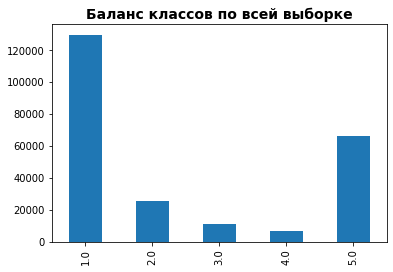

In [ ]:
train_df.grades.value_counts().sort_index().plot(kind='bar')
plt.title('Баланс классов по всей выборке', fontsize=14, weight='bold')
plt.show()

Явный дисбаланс (очень сильное доминирование оценок 1)

In [ ]:
# # train_df.groupby(['bank', 'grades']).count()
# bank_wise_dist = train_df.value_counts(subset=['bank', 'grades'], 
#                                        sort=False).reset_index()
# bank_wise_dist.rename(columns={0: 'count'}, inplace=True)
# # sns.barplot(data=bank_wise_dist, x='grades', hue='bank', estimator='count')
# fig = plt.figure(figsize=(19, 16))
# sns.countplot(data=train_df, x='grades', hue='bank', orient='v')
# plt.show()

In [ ]:
train_df['date'] = pd.to_datetime(train_df['date'], format='%d.%m.%Y %H:%M')

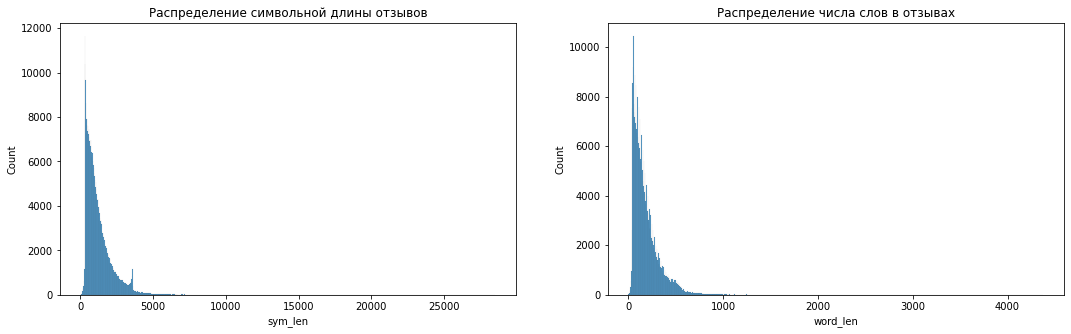

In [ ]:
train_df['sym_len'] = train_df.feeds.apply(len)
train_df['word_len'] = train_df.feeds.apply(lambda x: len(x.split()))
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
sns.histplot(data=train_df.sym_len, ax=ax[0])
sns.histplot(data=train_df.word_len, ax=ax[1])
ax[0].set_title('Распределение символьной длины отзывов')
ax[1].set_title('Распределение числа слов в отзывах')
plt.show()

In [ ]:
len(train_df[train_df['word_len'] > 512])

13023

In [ ]:
test_df.head(10)

,bank,feeds,date
0,sberbank,История такова: 27.01.2015 мне на телефон приш...,05.02.2015 17:33
1,alfabank,"Нельзя решить ни один вопрос оперативно, автоо...",03.03.2021 9:27
2,tcs,"Быстро, удобно, чего ещё нужно то. На сайтике ...",09.04.2018 7:40
3,pochtabank,Добрый день! Просто в шоке от ПАО «Почта Банк...,09.04.2020 9:57
4,sberbank,В течение выходных дней новогоднего периода 20...,12.01.2012 14:00
5,sberbank,В дополнительном офисе Архангельского ОСБ 8637...,10.07.2014 13:46
6,promsvyazbank,"Открыл счёт в данном банке, о чем очень жалею!...",06.05.2017 9:11
7,gazprombank,Пишу о неприятной ситуации! Снимал с карты 11 ...,05.12.2018 16:37
8,tcs,"Судя по сообщениям клиентов в форуме, в ТБ бол...",27.10.2017 10:40
9,sovcombank,Как-то с мужем мы обратились в офис на Семенов...,07.11.2017 9:55


In [ ]:
test_df.shape

(34114, 3)

In [ ]:
test_df.isna().sum()

bank     0
feeds    0
date     0
dtype: int64

# 3.Предобработка текстовых данных

In [ ]:
nltk.download('stopwords')  # скачаем стоп-слова для русского языка
print(stopwords.words('russian'))
stop = stopwords.words('russian') + list(punctuation)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
m = MorphAnalyzer()

In [ ]:
# for c in '!?()':
#   stop.pop(stop.index(c))
# print(stop)

In [ ]:
@lru_cache(maxsize=128)
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]

def preprocess_text(text, stop_w=stop, tokenizer=word_tokenize):  
    """функция предобработки текста"""
    text = re.sub(r'\n', ' ', text) 
    text = re.sub('[^А-Яа-яA-z\s]', ' ', text)  # ^А-Яа-яA-z\s!?()
    # приводим к нижнему регистру и разбиваем на слова по символу пробела
    text = tokenizer(text.lower())
    text = [w for w in text if (w not in stop_w) and (len(w) > 2)]
    text = lemmatize_text(text)
    return ' '.join(text)

In [ ]:
with Pool(8) as p:  # используем мультипроцессинг
    lemmas = list(tqdm(p.imap(preprocess_text, train_df['feeds']), total=len(train_df)))
    
train_df['lemmas'] = lemmas  # добавим в наш датафрейм колонку с очищенными текстами отзывов
train_df.sample(5)

100%|██████████| 350000/350000 [2:05:45<00:00, 46.39it/s]


,bank,feeds,grades,date,sym_len,word_len,lemmas
338756,gazprombank,"Есть такая служба ФССП точка, заблокировал мне...",NaN,2019-02-25 19:16:00,320,49,такой служба фссп точка заблокировать рубль ме...
24569,tcs,14 апреля 2019 года на сайте Тинькофф страхова...,1.0,2019-06-11 11:44:00,1341,208,апрель год сайт тинькофф страхование приобразе...
85575,sberbank,16.02.2013 г. я вносила деньги на счет своей ...,1.0,2013-03-14 23:25:00,4762,704,г вносить деньга счёт свой карта сбербанк отде...
16964,sberbank,Здравствуйте! Неоднократно было оставлено обра...,NaN,2020-02-18 11:20:00,1380,195,здравствуйте неоднократно оставить обращение б...
65794,homecreditbank,"Добрый вечер! Являюсь клиентом банка, была про...",NaN,2014-12-28 21:35:00,530,83,добрый вечер являться клиент банк просрочка да...


In [ ]:
with open(os.path.join(os.getcwd(), 'clean_text.txt'), 'w') as f:  
  for s in lemmas:
    f.write(s + '\n')

In [ ]:
# train_df.to_csv('train_clean.csv', index=False)

In [ ]:
# files.download('/content/train_clean.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Сохраним, чтобы не выполнять каждый раз этот (довольно долгий) препроцессинг

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP/bootcamp/train_clean.csv')
train_df.head()

,bank,feeds,grades,date,sym_len,word_len,lemmas
0,unicreditbank,Я очень редко пользуюсь банковскими продуктами...,5.0,2017-12-31 18:20:00,770,119,очень редко пользоваться банковский продукт не...
1,fk_otkritie,Я вместе с женой 15.11.2019 обратился в отделе...,1.0,2019-11-22 22:42:00,2749,405,вместе жена обратиться отделение банк открытие...
2,alfabank,Добрый день.Сегодня 27.12.2018 г около 15.40-1...,1.0,2018-12-27 23:20:00,867,128,добрый день сегодня г около банкомат адрес ряз...
3,vtb,"""Где карточку открывали, туда и идите..."" - эт...",2.0,2020-02-05 16:40:00,2860,462,карточка открывать туда идти этот фраза давно ...
4,promsvyazbank,При покупках в iTunes списываются завышенные с...,NaN,2016-02-26 15:48:00,1066,161,покупка itunes списываться завысить сумма прим...


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP/bootcamp/test_clean.csv')
test_df.head()

,bank,feeds,date,lemmas
0,sberbank,История такова: 27.01.2015 мне на телефон приш...,05.02.2015 17:33,история таков телефон прийти подряд смс списан...
1,alfabank,"Нельзя решить ни один вопрос оперативно, автоо...",03.03.2021 9:27,решить вопрос оперативно автоответчик отказыва...
2,tcs,"Быстро, удобно, чего ещё нужно то. На сайтике ...",09.04.2018 7:40,быстро удобно нужно сайтик быстро оформить док...
3,pochtabank,Добрый день! Просто в шоке от ПАО «Почта Банк...,09.04.2020 9:57,добрый день просто шок пао почта банк обратить...
4,sberbank,В течение выходных дней новогоднего периода 20...,12.01.2012 14:00,течение выходной день новогодний период банком...


# 4.Модели

## 4.1.Word2Vec

In [ ]:
class MyCorpus:
    """Класс итератора, который выдает предложения как список строк."""

    def __init__(self, path):
      self.path = path  # путь до нашего файла

    def __iter__(self):
        corpus_path = datapath(self.path)
        for line in open(corpus_path):
            yield line.split()  # считываем строчку и деим по пробелам

In [ ]:
sentences = MyCorpus('/content/drive/MyDrive/Colab Notebooks/NLP/bootcamp/clean_text.txt')
model = word2vec.Word2Vec(sentences=sentences, workers=4, sg=1,
                          min_count=12, window=6)  # vector_size=100,

In [ ]:
path_mod = '/content/drive/MyDrive/Colab Notebooks/NLP/bootcamp/bootcamp_w2v.model'
print("Saving model...")
model.save(path_mod)
print(f'Successfully saved to {path_mod}!')

Saving model...
Successfully saved to /content/drive/MyDrive/Colab Notebooks/NLP/bootcamp/bootcamp_w2v.model!


In [ ]:
# model.wv.save_word2vec_format('/content/drive/MyDrive/Colab Notebooks/NLP/bootcamp/bootcamp_w2v.bin', binary=True)

Подгрузим обученную выше модель

In [ ]:
model = word2vec.Word2Vec.load('/content/drive/MyDrive/Colab Notebooks/NLP/bootcamp/bootcamp_w2v.model')

In [ ]:
'ужас' in model.wv.vocab

True

In [ ]:
model.wv.get_vector('ужас')

array([-0.21812658,  0.01064814, -0.02525915, -0.03689817,  0.14159329,
        0.22889596, -0.10698   , -0.00517877,  0.42420483, -0.02871739,
       -0.28550893,  0.04127863, -0.2006897 ,  0.1463856 , -0.09537274,
        0.05192045,  0.41817275, -0.2678077 , -0.21539068, -0.02378392,
       -0.29292172,  0.329952  ,  0.4602768 ,  0.21724227, -0.35484338,
        0.07417253,  0.19143067, -0.29711154,  0.06530724, -0.11030419,
       -0.15170768,  0.43616268,  0.21601541,  0.08641481, -0.09610929,
       -0.12200428, -0.28291818, -0.14908737,  0.04424046,  0.06493042,
       -0.08899351,  0.17550354,  0.5087403 , -0.4848622 ,  0.36512437,
        0.08417723,  0.04227848, -0.11653157, -0.25008565,  0.4164191 ,
       -0.14669907,  0.01564481, -0.14279288, -0.53789186, -0.04275704,
        0.12528415, -0.20674357,  0.06965625, -0.05814482,  0.00797736,
        0.18449374,  0.6025482 ,  0.33969578, -0.26553488, -0.03410347,
        0.02584762, -0.22563119,  0.22408822,  0.16905272, -0.28

In [ ]:
print('Синонимы:')
print(model.wv.most_similar('ужас', topn=5))
print(model.wv.most_similar('прекрасный', topn=5))
print(model.wv.most_similar('банк', topn=5))
print(model.wv.most_similar('офис', topn=5))
print(model.wv.most_similar('клиент', topn=5))

print('Лишние слова:')
print('промсвязьбанк росбанк газпромбанк менеджер => лишнее:', 
      model.wv.doesnt_match('промсвязьбанк росбанк газпромбанк менеджер'.split()))
print('сотрудница специалист руководитель клиент => лишнее:', 
      model.wv.doesnt_match('сотрудница специалист руководитель клиент'.split()))
print('карта счёт кредитка мужчина => лишнее:', 
      model.wv.doesnt_match('карта счёт кредитка мужчина карточка'.split()))

Синонимы:
[('кошмар', 0.8376878499984741), ('жесть', 0.8085354566574097), ('шок', 0.7676982879638672), ('бардак', 0.71785569190979), ('беспредел', 0.7053205370903015)]
[('замечательный', 0.8475978970527649), ('отличный', 0.801703929901123), ('превосходный', 0.7504867315292358), ('хороший', 0.7279325127601624), ('великолепный', 0.7214755415916443)]
[('росбанк', 0.6799560189247131), ('промсвязьбанк', 0.6713772416114807), ('бак', 0.669198751449585), ('банкть', 0.6502624750137329), ('газпромбанк', 0.6407750844955444)]
[('отделение', 0.9143511652946472), ('филиал', 0.8281509876251221), ('отдаление', 0.7874304056167603), ('короленко', 0.7382216453552246), ('допофис', 0.7340496182441711)]
[('клинт', 0.731479287147522), ('клиетом', 0.6984604597091675), ('добросовесный', 0.6511321067810059), ('вкладчик', 0.6479739546775818), ('кклиент', 0.6427428722381592)]
Лишние слова:
промсвязьбанк росбанк газпромбанк менеджер => лишнее: менеджер
сотрудница специалист руководитель клиент => лишнее: клиент
ка

/usr/local/lib/python3.8/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


По внутренним (intrinsic) метрикам в ячейке выше, можно сделать вывод, что w2v обучился неплохо и смог извлечь некоторые закономерности о языке из текстов отзывов. Теперь представим каждый отзыв как среднее эмбеддингов слов этого отзыва из word2vec

In [ ]:
corp_to_embeds = []
with open('/content/drive/MyDrive/Colab Notebooks/NLP/bootcamp/clean_text.txt') as f:
  for l in f:
    lst = [model.wv.get_vector(w) for w in l.split() if w in model.wv.vocab]      
    corp_to_embeds.append(np.mean(lst, axis=0))

In [ ]:
train_df['w2v_embeds'] = corp_to_embeds
train_df

,bank,feeds,grades,date,sym_len,word_len,lemmas,w2v_embeds
0,unicreditbank,Я очень редко пользуюсь банковскими продуктами...,5.0,2017-12-31 18:20:00,770,119,очень редко пользоваться банковский продукт не...,"[-0.057296943, 0.1775573, 0.012814509, -0.0993..."
1,fk_otkritie,Я вместе с женой 15.11.2019 обратился в отделе...,1.0,2019-11-22 22:42:00,2749,405,вместе жена обратиться отделение банк открытие...,"[0.017619327, 0.26207352, 0.009155012, -0.1174..."
2,alfabank,Добрый день.Сегодня 27.12.2018 г около 15.40-1...,1.0,2018-12-27 23:20:00,867,128,добрый день сегодня г около банкомат адрес ряз...,"[-0.14303426, 0.2085096, -0.0039132936, -0.075..."
3,vtb,"""Где карточку открывали, туда и идите..."" - эт...",2.0,2020-02-05 16:40:00,2860,462,карточка открывать туда идти этот фраза давно ...,"[0.0048099444, 0.16611528, -0.0068816505, -0.1..."
4,promsvyazbank,При покупках в iTunes списываются завышенные с...,NaN,2016-02-26 15:48:00,1066,161,покупка itunes списываться завысить сумма прим...,"[-0.01643992, 0.17063482, -0.15326434, -0.2541..."
...,...,...,...,...,...,...,...,...
349995,investtorgbank,Хочу поделиться своим положительными опытом от...,5.0,2012-12-17 22:57:00,1927,294,хотеть поделиться свой положительный опыт полу...,"[-0.058487758, 0.18186063, -0.044076722, -0.13..."
349996,unicreditbank,Добрый день!Хочу оставить отзыв по банку Юникр...,1.0,2021-02-01 11:44:00,839,118,добрый день хотеть оставить отзыв банк юникред...,"[-0.00072882674, 0.13193616, -0.026931038, -0...."
349997,locko-bank,Доброго дня! Обратился в Локо Банк с просьбой ...,5.0,2020-04-24 11:39:00,498,70,добрый день обратиться локо банк просьба рестр...,"[0.057171892, 0.26056197, 0.07810278, -0.10941..."
349998,tcs,"Просрочил платеж на 5 дней, а мне уже взыскани...",NaN,2020-11-24 23:39:00,475,85,просрочить платёж день взыскание звонить предл...,"[-0.09745417, 0.14880887, -0.05855264, -0.1904..."


In [ ]:
embeds_df = train_df['w2v_embeds'].apply(pd.Series)

In [ ]:
train_df = pd.concat([train_df, embeds_df], axis=1)

In [ ]:
train_no_nan = train_df.dropna()  # удалим наблюдения с неизвестной оценкой отзыва
train_no_nan = train_no_nan.drop(columns=['feeds', 'date', 'sym_len', 'word_len',
                                          'lemmas', 'w2v_embeds'])
train_no_nan['grades'] = train_no_nan['grades'].astype('int16')
train_no_nan.sample(3)

,bank,grades,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
70106,bcs-bank,1,0.001686,0.186048,0.026936,-0.163402,0.058308,0.083783,0.055907,-0.061341,...,0.005223,0.003655,-0.152639,-0.148978,-0.239127,-0.121205,-0.042457,-0.072721,0.137279,-0.175973
293909,sberbank,1,0.036187,0.226068,0.030098,-0.116255,0.062635,0.040851,0.034893,-0.027520,...,0.067438,0.075596,-0.153849,-0.107110,-0.197793,-0.128305,0.010893,-0.060864,0.109057,-0.124233
295466,mkb,1,0.025165,0.153231,-0.065188,-0.148137,-0.045348,-0.107516,0.077699,-0.082065,...,0.035637,0.047773,-0.258526,-0.026189,-0.286055,-0.084403,-0.084994,-0.025244,0.210356,-0.123263


Теперь обучим модель, используя в качестве признаков название банка (их закодируем через one hot кодирование) и усредненный вектор эмбеддингов слов отзыва.

In [ ]:
X = train_no_nan.drop('grades', axis=1)
y = train_no_nan.grades

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=42, stratify=y)
print ("total train examples %s" % len(y_train))
print ("total test examples %s" % len(y_test))

total train examples 192200
total test examples 48050


Ниже код для undersampling, который удалял часть отзывов наиболее преобладающего класса (те, к которых оценка 1), но с undersampling'ом качество падало

In [ ]:
# np.random.seed(42)
# idx_drop = np.random.choice(y_train[y_train == 1].index, size=int(y_train[y_train == 1].shape[0] * 0.35), replace=False)
# X_train = X_train.drop(index=idx_drop)
# y_train = y_train.drop(index=idx_drop)

In [ ]:
# y_train.value_counts(normalize=True)

1    0.433126
5    0.340872
2    0.132452
3    0.057137
4    0.036413
Name: grades, dtype: float64

In [ ]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), ['bank'])  
], remainder='passthrough')

X_train_transf = column_transformer.fit_transform(X_train)
X_test_transf = column_transformer.transform(X_test)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Обучим модель LGBM на наших данных. Таким образом получается очень хороший бейзлайн, побить который оказалось достаточно нелегко

In [ ]:
lgbm = LGBMClassifier(max_depth=4, learning_rate=0.05, 
                      n_estimators=1000, random_state=42)
lgbm.fit(X_train_transf, y_train)

LGBMClassifier(learning_rate=0.07, max_depth=5, n_estimators=1000,
               random_state=42)

In [ ]:
print('micro f1 on train: {:.2f}'.format(f1_score(y_train, lgbm.predict(X_train_transf), average='micro')))
print('micro f1 on val: {:.2f}'.format(f1_score(y_test, lgbm.predict(X_test_transf), average='micro')))

micro f1 on train: 0.80
micro f1 on val: 0.79


In [ ]:
def grid_search(model, X, y, params, scoring='f1_micro', nfolds=3):    
    gscv = GridSearchCV(model, params, scoring=scoring, cv=nfolds, n_jobs=-1)
    gscv.fit(X, y)
    print('Best score: %.5f' % gscv.best_score_)
    print('Best params:', gscv.best_params_)
    return gscv

Ниже происходит обучения catboost, random forest, logreg и стекинга из всех этих моделей, но ничто из перечисленного (в том числе с перебором гиперпараметров) не помогло побить бейзлайн, который удалось побить только БЕРТом

In [ ]:
cbmodel = CatBoostClassifier(depth=6, learning_rate=0.05, n_estimators=800, 
                             verbose=False, random_state=42)
cbmodel.fit(X_train_transf, y_train)

In [ ]:
print('micro f1 on train: {:.2f}'.format(f1_score(y_train, cbmodel.predict(X_train_transf), average='micro')))
print('micro f1 on val: {:.2f}'.format(f1_score(y_test, cbmodel.predict(X_test_transf), average='micro')))

micro f1 on train: 0.78
micro f1 on val: 0.79


In [ ]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=10,
                             criterion='entropy',
                             random_state=42)
rfc.fit(X_train_transf, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, random_state=42)

In [ ]:
print('micro f1 on train: {:.2f}'.format(f1_score(y_train, rfc.predict(X_train_transf), average='micro')))
print('micro f1 on val: {:.2f}'.format(f1_score(y_test, rfc.predict(X_test_transf), average='micro')))

micro f1 on train: 0.73
micro f1 on val: 0.77


In [ ]:
lr = LogisticRegression(max_iter=5000, random_state=42)
lr.fit(X_train_transf, y_train)

LogisticRegression(max_iter=5000, random_state=42)

In [ ]:
print('micro f1 on train: {:.2f}'.format(f1_score(y_train, lr.predict(X_train_transf), average='micro')))
print('micro f1 on val: {:.2f}'.format(f1_score(y_test, lr.predict(X_test_transf), average='micro')))

micro f1 on train: 0.75
micro f1 on val: 0.79


In [ ]:
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_test_transf, y_test, train_size=0.3, 
                                                                    random_state=42, stratify=y_test)

In [ ]:
def get_blend_preds(data):
  df_stack_preds = pd.DataFrame({
      'lgbm': np.argmax(lgbm.predict_proba(data), axis=1) + 1,
      'cbmodel': np.argmax(cbmodel.predict_proba(data), axis=1) + 1,
      'rfc': np.argmax(rfc.predict_proba(data), axis=1) + 1,
      'lr': np.argmax(lr.predict_proba(data), axis=1) + 1
      })
  return df_stack_preds.mode(axis=1)[0]

In [ ]:
print('micro f1 on train: {:.2f}'.format(f1_score(y_train_val, get_blend_preds(X_train_val), average='micro')))
print('micro f1 on val: {:.2f}'.format(f1_score(y_test_val, get_blend_preds(X_test_val), average='micro')))

micro f1 on train: 0.79
micro f1 on val: 0.79


In [ ]:
stacked = StackingClassifier([('lgbm', lgbm), ('catboost', cbmodel), 
                              ('lr', lr)],
                              final_estimator=LogisticRegression(max_iter=200),
                              stack_method='auto',
                              n_jobs=-1)
stacked.fit(X_train_val, y_train_val)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


StackingClassifier(estimators=[('lgbm',
                                LGBMClassifier(learning_rate=0.07, max_depth=5,
                                               n_estimators=1000,
                                               random_state=42)),
                               ('lr',
                                LogisticRegression(max_iter=5000,
                                                   random_state=42))],
                   final_estimator=LogisticRegression(), n_jobs=-1)

In [ ]:
print('micro f1 on train: {:.2f}'.format(f1_score(y_train_val, stacked.predict(X_train_val), average='micro')))
print('micro f1 on val: {:.2f}'.format(f1_score(y_test_val, stacked.predict(X_test_val), average='micro')))

micro f1 on train: 0.82
micro f1 on val: 0.79


Повторим препроцессинг для тестовой части

In [ ]:
with Pool(8) as p:
    lemmas_test = list(tqdm(p.imap(preprocess_text, test_df['feeds']), total=len(test_df)))
    
test_df['lemmas'] = lemmas_test
test_df.sample(5)

100%|██████████| 34114/34114 [10:41<00:00, 53.20it/s]


,bank,feeds,date,lemmas
25916,rsb,"Видит бог, не хотел тут писать, но достали... ...",24.12.2010 17:05,видеть бог хотеть писать достать короче написа...
7002,bnpparibaseast,После оформления автокредита и регистрации маш...,15.08.2017 15:48,оформление автокредит регистрация машина услов...
22562,alfabank,"Поставила единицу банку, а не оператору! Опера...",28.01.2020 15:25,поставить единица банк оператор оператор ирина...
4869,rshb,26 мая получили предварительное решение о Сель...,03.09.2020 5:29,май получить предварительный решение сельхозип...
1471,homecreditbank,Хочу поделиться как Хоум Кредит работает с дол...,23.05.2014 3:08,хотеть поделиться хоум кредит работать должник...


In [ ]:
test_df.to_csv('/content/drive/MyDrive/Colab Notebooks/NLP/bootcamp/test_clean.csv', index=False)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/NLP/bootcamp/clean_text_test.txt', 'w') as f:  
  for s in lemmas_test:
    f.write(s + '\n')

In [ ]:
corp_to_embeds = []
with open('/content/drive/MyDrive/Colab Notebooks/NLP/bootcamp/clean_text_test.txt') as f:
  for l in f:
    lst = [model.wv.get_vector(w) for w in l.split() if w in model.wv.vocab]      
    corp_to_embeds.append(np.mean(lst, axis=0))

In [ ]:
test_df['w2v_embeds'] = corp_to_embeds
test_df

,bank,feeds,date,lemmas,w2v_embeds
0,sberbank,История такова: 27.01.2015 мне на телефон приш...,05.02.2015 17:33,история таков телефон прийти подряд смс списан...,"[-0.017935527, 0.24498321, -0.010504065, -0.13..."
1,alfabank,"Нельзя решить ни один вопрос оперативно, автоо...",03.03.2021 9:27,решить вопрос оперативно автоответчик отказыва...,"[-0.07190745, 0.23438267, 0.07242206, -0.19762..."
2,tcs,"Быстро, удобно, чего ещё нужно то. На сайтике ...",09.04.2018 7:40,быстро удобно нужно сайтик быстро оформить док...,"[-0.0010693996, 0.16758825, 0.022258865, -0.13..."
3,pochtabank,Добрый день! Просто в шоке от ПАО «Почта Банк...,09.04.2020 9:57,добрый день просто шок пао почта банк обратить...,"[0.104477525, 0.17261854, 0.02447445, -0.16589..."
4,sberbank,В течение выходных дней новогоднего периода 20...,12.01.2012 14:00,течение выходной день новогодний период банком...,"[-0.13400935, 0.14759469, 0.029794397, -0.0531..."
...,...,...,...,...,...
34109,alfabank,"Никогда не думал, что Альфа банк такой ужасный...",23.06.2019 12:40,думать альфа банк ужасный банк юридический лиц...,"[0.08979863, 0.19114274, 0.06336534, -0.085040..."
34110,v-express-bank,Добрый день. Даааа ужжжж... всегда выбирала им...,20.12.2013 3:46,добрый день даааа ужжжж выбирать именно банк с...,"[-0.100378044, 0.17155983, -0.03493069, -0.123..."
34111,rsb,Приходиться повторно писать об отношении этого...,13.11.2011 17:20,приходиться повторно писать отношение банк сво...,"[-0.017904744, 0.19210382, -0.028616069, -0.00..."
34112,rosbank,"Я долго сотрудничаю с Росбанком, не один креди...",28.02.2017 9:24,долго сотрудничать росбанк кредит взять однако...,"[-0.083377175, 0.0935361, -0.06689843, -0.0502..."


In [ ]:
embeds_df = test_df['w2v_embeds'].apply(pd.Series)

In [ ]:
test_df = pd.concat([test_df, embeds_df], axis=1)

In [ ]:
test_new = test_df.drop(columns=['feeds', 'date', 'lemmas', 'w2v_embeds'])
test_new.sample()

,bank,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
9995,sovcombank,-0.034082,0.158413,-0.126758,-0.121242,0.087948,0.053074,0.075476,0.004097,0.054328,...,-0.099554,-0.002889,-0.223752,-0.059878,-0.137715,-0.025144,0.044454,-0.17744,0.134562,-0.158826


In [ ]:
test_new = column_transformer.transform(test_new)
sol = pd.DataFrame({'inds': test_df.index,
                    'grades': lgbm.predict(test_new)})
sol

,inds,grades
0,0,1
1,1,1
2,2,5
3,3,1
4,4,1
...,...,...
34109,34109,1
34110,34110,1
34111,34111,1
34112,34112,1


In [ ]:
sol.to_csv('w2v_lgbm.csv', index=False)

## ПРИМЕЧАНИЕ

Далее идет попытка побить бейзлайн с помощью FastText и файнтюнинга предобученного для русского языка Bert из HuggingFace (конкретнее tiny-rubert). Но ни одна из этих моделей не смогла побить бейзлайн. Его поможет преодолеть Bert из tensorflow, см. код в другом ноутбуке)

## 4.2.FastText

In [ ]:
!git clone https://github.com/facebookresearch/fastText.git 
!pip3 install fastText/. 

Cloning into 'fastText'...
remote: Enumerating objects: 3930, done.
remote: Counting objects: 100% (944/944), done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 3930 (delta 854), reused 804 (delta 804), pack-reused 2986
Receiving objects: 100% (3930/3930), 8.24 MiB | 42.20 MiB/s, done.
Resolving deltas: 100% (2505/2505), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./fastText
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Using cached pybind11-2.10.1-py3-none-any.whl (216 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp38-cp38-linux_x86_64.

In [ ]:
import fasttext

# # так можно обучить свою модель 
# ft_model = fasttext.train_unsupervised('clean_text.txt', minn=3, maxn=4, dim=300)

In [ ]:
train_no_nan = train_df.dropna()

In [ ]:
# train_no_nan.sample()

In [ ]:
train_no_nan = train_df.dropna()
X = train_no_nan.lemmas
y = train_no_nan.grades.astype('int32')

X, y = np.array(X), np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=42, stratify=y)
print ("total train examples %s" % len(y_train))
print ("total test examples %s" % len(y_test))

total train examples 168175
total test examples 72075


In [ ]:
with open('data.train.txt', 'w+') as outfile:
    for i in range(len(X_train)):
        outfile.write('__label__' + str(y_train[i]) + ' ' + X_train[i] + '\n')
    
with open('test.txt', 'w+') as outfile:
    for i in range(len(X_test)):
        outfile.write('__label__' + str(y_test[i]) + ' ' + X_test[i] + '\n')

In [ ]:
classifier = fasttext.train_supervised('data.train.txt', lr=0.5, epoch=20,
                                       minCount=12,
                                       minn=3, maxn=5, wordNgrams=5)
result = classifier.test('test.txt')

print('Precision:', result[1])
print('Recall:', result[2])
print('Number of examples:', result[0])

Precision: 0.792258064516129
Recall: 0.792258064516129
Number of examples: 72075


In [ ]:
with open('test.txt') as f:
  print(classifier.predict(f.readline().strip()))

(('__label__5',), array([0.99913722]))


In [ ]:
classifier.get_nearest_neighbors('банк')

[(0.9995318055152893, 'гла'),
 (0.9994478225708008, 'rurуплата'),
 (0.9993610978126526, 'заскринива'),
 (0.9990193247795105, 'неискушённый'),
 (0.9989594221115112, 'ruнаписать'),
 (0.9988638758659363, 'интервенция'),
 (0.9987906813621521, 'своха'),
 (0.998740017414093, 'сведетельствовать'),
 (0.9987244009971619, 'глазюк'),
 (0.9986460208892822, 'упражнять')]

In [ ]:
classifier.get_nearest_neighbors('клиент')

[(0.9997479915618896, 'зарок'),
 (0.9995205402374268, 'непропорционально'),
 (0.9991280436515808, 'кклиент'),
 (0.998944878578186, 'заемщикапосле'),
 (0.9989281892776489, 'матюкнуться'),
 (0.9988179802894592, 'этоть'),
 (0.9987621307373047, 'зация'),
 (0.9986922144889832, 'райфайзенд'),
 (0.9984851479530334, 'райфайзан'),
 (0.9984176754951477, 'вважа')]

In [ ]:
classifier.get_nearest_neighbors('опыт')

[(0.9997687935829163, 'варенцов'),
 (0.999112606048584, 'банкстараться'),
 (0.998924970626831, 'сберов'),
 (0.9988054633140564, 'возврващаться'),
 (0.9984949827194214, 'аносов'),
 (0.9984449744224548, 'processed'),
 (0.9983326196670532, 'доблестный'),
 (0.9982945322990417, 's'),
 (0.998286247253418, 'молоканов'),
 (0.9982082843780518, 'подглядеть')]

In [ ]:
import fasttext.util
# fasttext.util.download_model('ru', dimension=100) 
# ft = fasttext.load_model('cc.ru.300.bin')  # скачивание предобученного fasttext, но он оказался слишком тяжелым

In [ ]:
example_feed = 'Отличный банк, остаюсь вашим преданным клиентом'

In [ ]:
np.argmax(classifier.predict(example_feed, k=5)[1])

0

In [ ]:
with Pool(8) as p:
    lemmas_test = list(tqdm(p.imap(preprocess_text, test_df['feeds']), total=len(test_df)))
    
test_df['lemmas'] = lemmas_test
test_df.sample(5)

100%|██████████| 34114/34114 [08:38<00:00, 65.74it/s]


,bank,feeds,date,lemmas
8931,vtb,"Как оформить кредитку на жалкие 20к - нет, а к...",07.06.2020 13:27,оформить кредитка жалкий заявление писать кото...
27449,fk_otkritie,"Конечно, президент Шишханов не читает то, что ...",09.03.2017 21:03,президент шишхан читать писать банк сайт поэто...
29630,vtb,Недавно столкнулась с проблемой взаимопонимани...,24.12.2019 12:08,недавно столкнуться проблема взаимопонимание д...
21969,fk_otkritie,Добрый день всем форумчанам!Вчера получил стра...,21.10.2016 20:39,добрый день весь форумчанин вчера получить стр...
32431,trust,16 января зашли с женой в отделение на Автозав...,23.01.2014 21:29,январь заслать жена отделение автозаводский ул...


In [ ]:
preds = test_df.lemmas.apply(lambda x: np.argmax(classifier.predict(x, k=5)[1]) + 1)

In [ ]:
classifier.predict(test_df.lemmas[15], k=5)[1]

array([8.52814138e-01, 1.22686833e-01, 2.30844747e-02, 8.57028528e-04,
       6.07431575e-04])

In [ ]:
sol = pd.DataFrame({'inds': test_df.index,
                    'grades': preds})
sol

,inds,grades
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
34109,34109,1
34110,34110,1
34111,34111,1
34112,34112,1


In [ ]:
sol.to_csv('fast_text.csv', index=False)

In [ ]:
sol.grades.value_counts(normalize=True)

1    1.0
Name: grades, dtype: float64

## 4.3.Bert

In [ ]:
PRE_TRAINED_MODEL_NAME = 'cointegrated/rubert-tiny2'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/401 [00:00<?, ?B/s]

In [ ]:
sample_txt = 'Я устал от всего этого. Нету человеческих сил больше так существовать'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Я устал от всего этого. Нету человеческих сил больше так существовать
   Tokens: ['Я', 'устал', 'от', 'всего', 'этого', '.', 'Нет', '##у', 'человеческих', 'сил', 'больше', 'так', 'существовать']
Token IDs: [311, 56744, 733, 4983, 3136, 18, 30616, 644, 40372, 7373, 8281, 1908, 39290]


In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  # max_length=512,
  add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
  return_token_type_ids=False,
  # pad_to_max_length=True,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Вернуть тензор PyTorch
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      # pad_to_max_length=True,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
train_df = train_df.dropna()
train_df['grades'] = train_df['grades'].astype('int8') - 1

<ipython-input-12-3074085544db>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['grades'] = train_df['grades'].astype('int8') - 1


In [ ]:
# np.random.seed(42)
# idxs = np.random.choice(train_df.index, size=int(train_df.shape[0] * 0.75), replace=False)

In [ ]:
# df_train, df_test = train_test_split(train_df[:int(len(train_df) * 0.7)], test_size=0.3, random_state=RANDOM_SEED)
# df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_train, df_test = train_test_split(train_df, train_size=45000, test_size=10000, stratify=train_df.grades, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, stratify=df_test.grades, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((45000, 7), (5000, 7), (5000, 7))

In [ ]:
np.random.seed(42)
idx_drop = np.random.choice(df_train[df_train.grades == 0].index, size=int(df_train.shape[0] * 0.4), replace=False)
df_train = df_train.drop(index=idx_drop)

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = CustomDataset(
    reviews=df.feeds.to_numpy(), #df.lemmas.to_numpy()
    targets=df.grades.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [ ]:
BATCH_SIZE = 64
MAX_LEN = 512
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([64, 512])
torch.Size([64, 512])
torch.Size([64])


In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/715 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/118M [00:00<?, ?B/s]

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
outputs = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [ ]:
outputs.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [ ]:
last_hidden_state = outputs['last_hidden_state']

In [ ]:
last_hidden_state.shape

torch.Size([1, 2048, 312])

In [ ]:
train_df.loc[16]['lemmas']

'давно банк приостановить операция счёт карта написать объяснение банк оно устроить время стать мало просто забить это дело несмотря блок банк продолжать списывать обслуживание счёт пакет комфорт отключить послать далее взять комиссия карта мой случай это комбренд аэрофлот сумма рубль пара звонить банк обьяснять ситуация сказать позвонить сам комиссия убрать сегодня позвонить горячий линия сказать мочь заявление составить необоснованно карта активный понимать активный карта это карта который человек пользоваться мочь ограничение банк пользоваться операция год сниматься оплата общий просьба обнулить комиссия сказать какой именно объяснение банк требоваться санкт петербург отнести'

In [ ]:
sample_txt = train_df.loc[16]['lemmas']

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Вернуть тензор PyTorch
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
last_hidden_state = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)['last_hidden_state']

In [ ]:
emb0 = last_hidden_state[0, 17]
emb0.shape

torch.Size([312])

In [ ]:
class CustomClassifier(nn.Module):
  def __init__(self, n_classes):
    super(CustomClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    for param in self.bert.base_model.parameters():
        param.requires_grad = False
    self.drop = nn.Dropout(p=0.5)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    outputs = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(outputs["pooler_output"])
    return self.out(output)

# class CustomClassifier(nn.Module):
#   def __init__(self, n_classes):
#     super(CustomClassifier, self).__init__()
#     # self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
#     self.bert = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, num_labels=256)
#     for param in self.bert.bert.parameters():
#         param.requires_grad = False
#     self.drop = nn.Dropout(p=0.4)
#     self.out = nn.Linear(256, n_classes)
  
#   def forward(self, input_ids, attention_mask):
#     outputs = self.bert(
#       input_ids=input_ids,
#       attention_mask=attention_mask
#     )
#     # output = self.drop(outputs["pooler_output"])
#     return outputs # self.out(output)

In [ ]:
model = CustomClassifier(5)
model = model.to(device)

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model

CustomClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

NameError: ignored

In [ ]:
import torch.nn.functional as F

In [ ]:
EPOCHS = 15

optimizer = AdamW(model.parameters(), lr=6e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=int(total_steps * 0.6),
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='micro')

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  predictions, true_vals = [], []

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    logits = outputs.detach().cpu().numpy() # new
    label_ids = targets.cpu().numpy()
    predictions.append(logits)
    true_vals.append(label_ids)

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
    
  predictions = np.concatenate(predictions, axis=0)
  true_vals = np.concatenate(true_vals, axis=0)
  return correct_predictions.double() / n_examples, np.mean(losses), predictions, true_vals

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  predictions, true_vals = [], []
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

      logits = outputs.detach().cpu().numpy() # new
      label_ids = targets.cpu().numpy()
      predictions.append(logits)
      true_vals.append(label_ids)
    
  predictions = np.concatenate(predictions, axis=0)
  true_vals = np.concatenate(true_vals, axis=0)

  return correct_predictions.double() / n_examples, np.mean(losses), predictions, true_vals

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss, preds, true_vals = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )
  train_f1 = f1_score_func(preds, true_vals)

  print(f'Train loss {train_loss} accuracy {train_acc}')
  print(f'Train f1 micro {train_f1}')

  val_acc, val_loss, preds, true_vals = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )
  val_f1 = f1_score_func(preds, true_vals)
  print(f'Val loss {val_loss} accuracy {val_acc}')
  print(f'Val f1 micro {val_f1}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc
  if epoch > 10:
    ask_proceed = input('Continue learning?')
    if ask_proceed == 'y':
      continue
    else:
      break

Epoch 1/15
----------
Train loss 1.6093092812181085 accuracy 0.20851851851851852


NameError: ignored

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
----------
Train loss 0.8181200992192653 accuracy 0.6656278149946676
Val loss 0.739283567234393 accuracy 0.732045104815721

Epoch 2/5
----------
Train loss 0.727063705786964 accuracy 0.6987709797993393
Val loss 0.729207068152966 accuracy 0.7219545420145809

Epoch 3/5
----------
Train loss 0.6860323692394408 accuracy 0.7160414574295151
Val loss 0.7195238119171512 accuracy 0.7188264675462274

Epoch 4/5
----------
Train loss 0.6540170898500657 accuracy 0.7309822843002246
Val loss 0.7141241410086232 accuracy 0.7223833909336292

Epoch 5/5
----------
Train loss 0.6294989548179487 accuracy 0.7412223936385003
Val loss 0.7523917575997691 accuracy 0.7027824726924143

CPU times: user 56min 42s, sys: 13.7 s, total: 56min 55s
Wall time: 1h 7min 30s


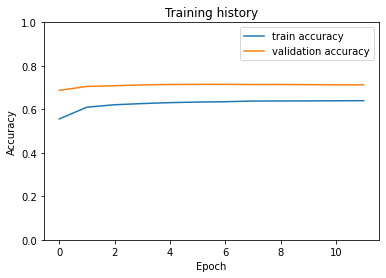

In [ ]:
plt.plot([x.cpu() for x in history['train_acc']], label='train accuracy')
plt.plot([x.cpu() for x in history['val_acc']], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.72      0.77     21420
           1       0.23      0.42      0.29      4258
           2       0.24      0.15      0.19      1836
           3       0.29      0.18      0.22      1170
           4       0.88      0.94      0.91     10958

    accuracy                           0.70     39642
   macro avg       0.50      0.48      0.48     39642
weighted avg       0.74      0.70      0.72     39642



In [ ]:
def bert_preds(text, model=model, tokenizer=tokenizer):
  encoded_review = tokenizer.encode_plus(
  text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt')
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output[0], dim=1)
  return prediction.cpu().numpy()[0]

In [ ]:
preds = test_df.lemmas.apply(lambda x: bert_preds(x)) + 1

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
sol = pd.DataFrame({'inds': test_df.index,
                    'grades': preds})
sol.to_csv('bert_15_epochs.csv', index=False)

In [ ]:
class CustomDataset(Dataset):

  def __init__(self, texts, targets, tokenizer, max_len=512):
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    target = self.targets[idx]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
from transformers import BertForSequenceClassification
model_path = 'cointegrated/rubert-tiny'
model = BertForSequenceClassification.from_pretrained(model_path)

In [ ]:
out_features = model.bert.encoder.layer[1].output.dense.out_features
model.classifier = torch.nn.Linear(312, 2)

In [ ]:
class BertClassifier:

    def __init__(self, model_path, tokenizer_path, n_classes=2, epochs=1, model_save_path='/content/bert.pt'):
        self.model = BertForSequenceClassification.from_pretrained(model_path)
        self.tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model_save_path=model_save_path
        self.max_len = 512
        self.epochs = epochs
        self.out_features = self.model.bert.encoder.layer[1].output.dense.out_features
        self.model.classifier = torch.nn.Linear(self.out_features, n_classes)
        self.model.to(self.device)

In [ ]:
train_set = CustomDataset(X_train, y_train, tokenizer)
train_loader = DataLoader(train_set, batch_size=2, shuffle=True)

In [ ]:
from transformers import AdamW
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)